In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.neighbors import KernelDensity

In [2]:
df = pd.read_excel("cf.xlsx", sheet_name = "18FacStaff", dtype={'ZIP': str, 'FAC STAFF': str}) 

In [3]:
df.head()

,ZIP,FAC STAFF,Distance
0,07078,FAC,170.0
1,13905,FAC,261.0
2,16648,FAC,234.0
3,17363,FAC,85.9
4,19145,FAC,79.1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 3 columns):
ZIP          550 non-null object
FAC STAFF    555 non-null object
Distance     550 non-null float64
dtypes: float64(1), object(2)
memory usage: 13.1+ KB


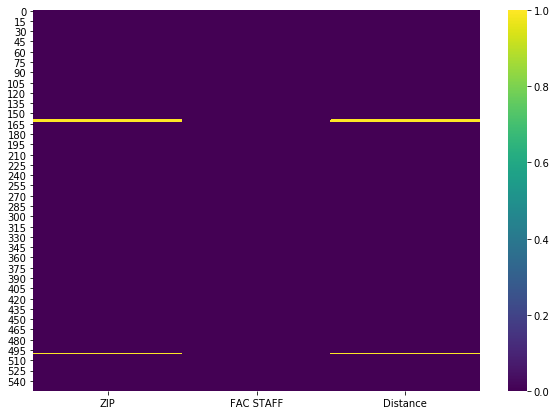

In [5]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(), cmap = 'viridis')

In [6]:
values = {'ZIP': 21620, 'FAC STAFF': np.nan, 'Distance':3}
df.fillna(values, inplace = True) 

In [7]:
df.ZIP = df.ZIP.astype(str) 

In [8]:
df['zips'] = df['ZIP'].str.split('-').str.get(0) 
df.drop(['ZIP'], axis = 1, inplace = True) 

In [9]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 3 columns):
FAC STAFF    555 non-null object
Distance     555 non-null float64
zips         555 non-null object
dtypes: float64(1), object(2)
memory usage: 13.1+ KB


In [10]:
df.loc[df['Distance'] > 150, 'Distance'] = 3 

#### Faculty footprint

In [11]:
df2 = df[df['FAC STAFF'] == "FAC"]['Distance']

In [12]:
df2.count() 

163

In [13]:
(df2*2*(70+90)).sum()

1366976.0

In [14]:
df2.sum()/df2.count()

26.207361963190184

#### Staff footprint

In [15]:
df3 = df[df['FAC STAFF'] == "STAFF"]['Distance']
df3.count() 

392

In [16]:
(df3*2*(70+90+(72-20))).sum()

2563080.0

In [17]:
(df3).sum()/392 

15.420918367346939

In [18]:
df.head()

,FAC STAFF,Distance,zips
0,FAC,3.0,07078
1,FAC,3.0,13905
2,FAC,3.0,16648
3,FAC,85.9,17363
4,FAC,79.1,19145


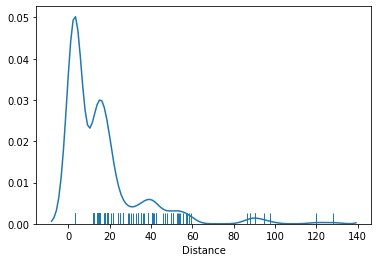

In [19]:
sns.distplot(df3, hist=False, rug=True);

(0, 5)

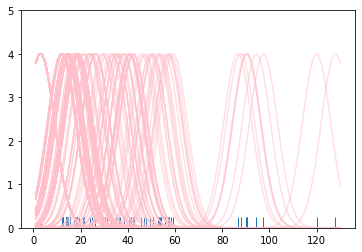

In [20]:
from scipy import stats
# setting up the x-axis for the plot
x_min = df3.min() -2
x_max = df3.max() +2

# 100 equally spaced points from x_min to x_max
x_axis = np.linspace(x_min, x_max, 100)

bandwidth = ((4*df3.std()**5)/(3*len(df3)))**.2
sns.rugplot(df3)
# create an empty kernel list
kernel_list = []

# plot each basis function
for data in df3:
    
    # Create a kernel for each point and append to list
    kernel = stats.norm(data, bandwidth).pdf(x_axis)
 
    kernel_list.append(kernel)
    
    # scale for plotting
    kernel = kernel/kernel.max()
    kernel = kernel*4
    plt.plot(x_axis, kernel, color = "pink", alpha = 0.5)
plt.ylim(0,5)

In [21]:
from scipy.stats import skew
skew(df3)

2.626936693375468

In [22]:
df3.describe()

count    392.000000
mean      15.420918
std       18.617682
min        3.000000
25%        3.000000
50%       12.100000
75%       18.600000
max      128.000000
Name: Distance, dtype: float64

In [23]:
def plot_prob_density(df_dist, field, x_start, x_end):
    plt.figure(figsize = (12,7))
    
    unit = 1.5
    x = np.linspace(df_dist.min() - unit, df_dist.max() + unit, 1000)[:, np.newaxis]
    
    # plot the data using normalized histogram
    plt.hist(df_dist, bins = 20, density = True, label = "distance", color = "orange", alpha = 0.3)
    
    # do kernel density estimation
    kd_dist = KernelDensity(kernel = "gaussian", bandwidth = 0.5).fit(df_dist)
    
    # plot the estimated density 
    kd_vals_dist = np.exp(kd_dist.score_samples(x))
    
    plt.plot(x, kd_vals_dist, color='orange')
    
    plt.axvline(x = x_start, color='red', linestyle='dashed')
    plt.axvline(x = x_end  , color='red', linestyle='dashed')
    
    # Show the plots
    plt.xlabel(field, fontsize=15)
    plt.ylabel('Probability Density', fontsize=15)
    plt.legend(fontsize=15)
    plt.show()
    gc.collect()
    return kd_dist

In [24]:
def probability(start_value, end_value, eval_points, kd):
    
    # Number of evaluation points
    N = eval_points
    step = (end_value - start_value) / (N - 1)
    x = np.linspace(start_value, end_value, N)[:,np.newaxis]
    kd_vals = np.exp(kd.score_samples(x))
    probability = np.sum(kd_vals * step)
    return probability.round(4)

In [25]:
data_distance = np.array(df3).reshape(-1, 1)

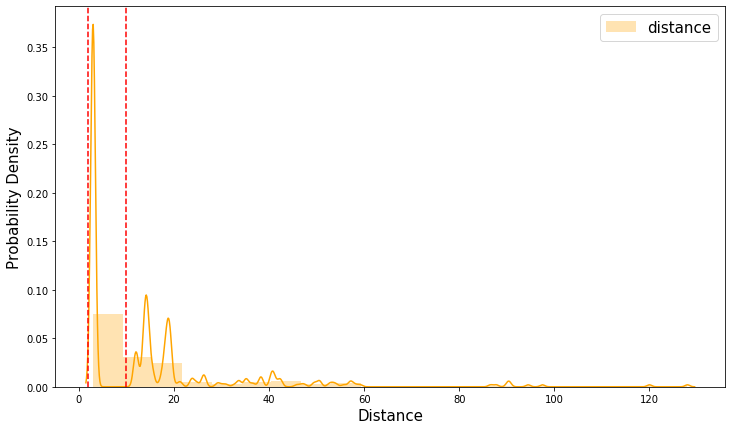

In [26]:
field = "Distance"
kd_dist = plot_prob_density(data_distance, field, x_start = 2, x_end = 10)

In [27]:
print("Probability of one staff living 2-20 miles from WAC: {}\n"
      .format(probability(start_value = 2, 
                              end_value = 20, 
                              eval_points = 100, 
                              kd = kd_dist))) 

Probability of one staff living 2-20 miles from WAC: 0.8029



* Staff who live less than 20 miles from campus

In [28]:
(df3 < 21).sum()

319

* Total count of staff

In [29]:
df3.count()

392

* Total percent of staff living withing 20 miles from campus

In [30]:
319/392

0.8137755102040817

* Total number of student's living off-campus 236

In [31]:
print("Total percent of student's who have an 81% chance of living 2-20 miles from campus:", (236*81.38)/319) 
print("Total number of student's who live 2-20 miles from WAC:", round((6/10)*236)) 

Total percent of student's who have an 81% chance of living 2-20 miles from campus: 60.2058934169279
Total number of student's who live 2-20 miles from WAC: 142
